<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BBANDS" data-toc-modified-id="BBANDS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BBANDS</a></span></li><li><span><a href="#RSI-oscillator" data-toc-modified-id="RSI-oscillator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>RSI oscillator</a></span></li></ul></div>

In [1]:
from talib import BBANDS
from utils import generateCV, hurst, hl
from numba import njit, prange

gazp = pd.read_csv("gazp.csv", parse_dates=["Date"])
ts = gazp.sort_values("Date")["Close"].values

cv = generateCV(gazp, 10000)
train_idx = cv[0][0]
test_idx = cv[0][1]

train = ts[train_idx]
test = ts[test_idx]

# BBANDS

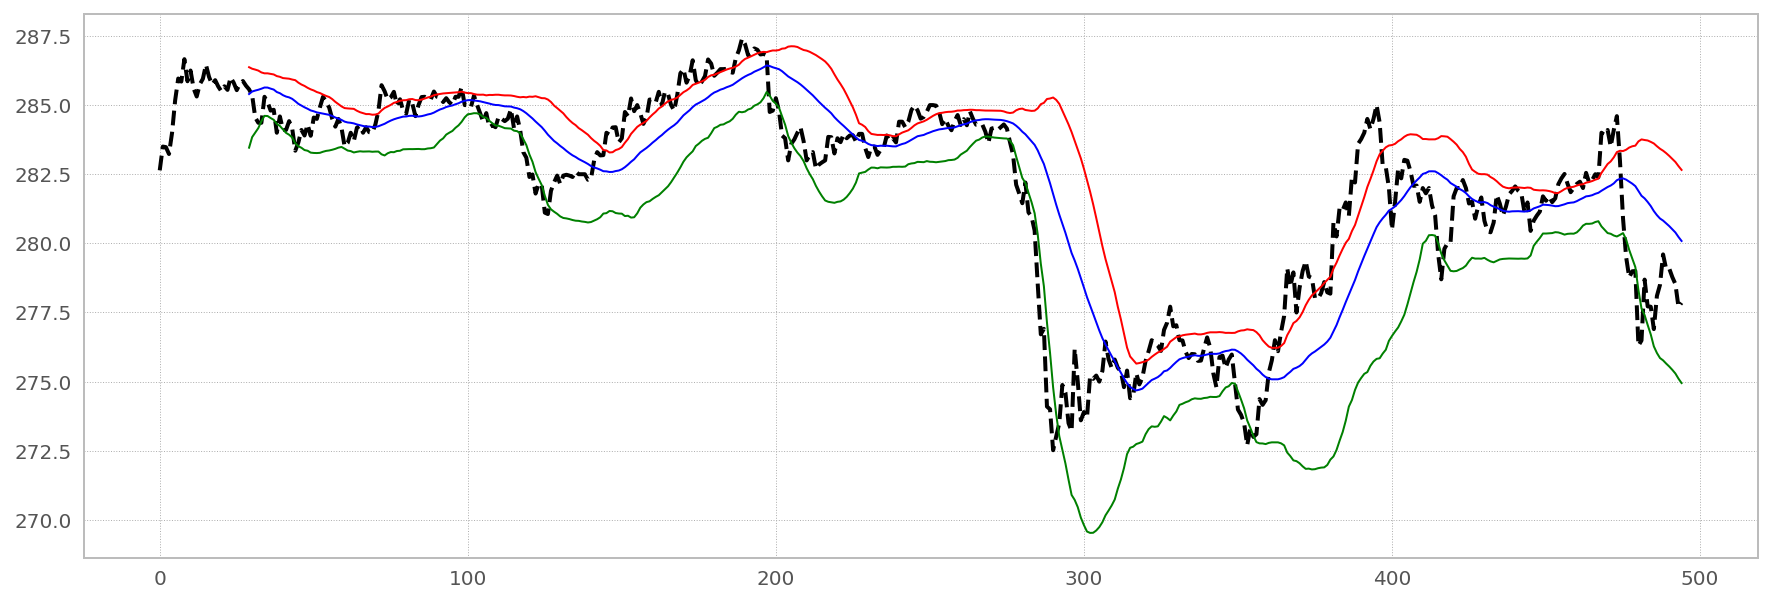

In [2]:
upper, middle, lower = BBANDS(test, 30, 1)
plt.plot(test, c="black", linestyle="--", linewidth="2")
plt.plot(upper, c="red")
plt.plot(lower, c="green")
plt.plot(middle, c="blue");

In [3]:
@njit
def crossup(x, y, i):
    if x[i - 1] < y[i - 1] and x[i] > y[i]:
        return 1
    else:
        return 0


@njit
def crossdown(x, y, i):
    if x[i - 1] > y[i - 1] and x[i] < y[i]:
        return 1
    else:
        return 0


@njit
def BBANDS_signal(price, upper, middle, lower):

    L = price.shape[0]
    out = np.empty(L, dtype=np.int64)
    out[0] = 0
    i = 1

    while i < L:

        if crossup(price, lower, i):
            while (
                not (crossup(price, middle, i) or crossdown(price, lower, i)) and i < L
            ):
                out[i] = 1
                i += 1

        if crossdown(price, upper, i):
            while (
                not (crossdown(price, middle, i) or crossup(price, upper, i)) and i < L
            ):
                out[i] = -1
                i += 1

        out[i] = 0
        i += 1

    return out


out = BBANDS_signal(test, upper, middle, lower)
%timeit -n100 -r100 BBANDS_signal(test, upper, middle, lower)

2.35 µs ± 13.1 ns per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [4]:
@njit
def crossup(x, y, i):
    if x[i - 1] < y[i - 1] and x[i] > y[i]:
        return 1
    else:
        return 0


@njit
def crossdown(x, y, i):
    if x[i - 1] > y[i - 1] and x[i] < y[i]:
        return 1
    else:
        return 0


@njit
def BBANDS_return(price, upper, middle, lower):

    L = price.shape[0]
    out = np.empty(L, dtype=np.float64)
    out[0] = 0.0
    i = 1

    while i < L - 2:

        if crossup(price, lower, i):
            while (
                not (crossup(price, middle, i) or crossdown(price, lower, i)) and i < L
            ):
                out[i] = price[i + 2] / price[i + 1] - 1.0
                i += 1

        if crossdown(price, upper, i):
            while (
                not (crossdown(price, middle, i) or crossup(price, upper, i)) and i < L
            ):
                out[i] = price[i + 1] / price[i + 2] - 1.0
                i += 1

        out[i] = 0.0
        i += 1

    out[-2:] = 0
    return out


ret = BBANDS_return(test, upper, middle, lower)
%timeit -n100 -r100 BBANDS_return(test, upper, middle, lower)

2.5 µs ± 15.9 ns per loop (mean ± std. dev. of 100 runs, 100 loops each)


In [5]:
np.multiply.reduce(1 + ret)

1.0044811090432104

In [6]:
def gen_BBANDS(ts, idx, l, s):
    """
    Arguments:
        ts: np.ndarray - Close prices
        idx: [int]- CV id
        l: int - lookback
        s: int - number of std above/below
    Returns:
        return generated by the BB strategy
    """
    min_idx = idx[0]
    max_idx = idx[-1]
    upper, middle, lower = BBANDS(ts[min_idx - l : max_idx + 1], l, s)
    upper, middle, lower = upper[l:], middle[l:], lower[l:]
    ts = ts[idx]
    return BBANDS_return(ts, upper, middle, lower)


ret = gen_BBANDS(ts, test_idx, 20, 2)
%timeit gen_BBANDS(ts, test_idx, 20, 2)

12.8 µs ± 80.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# RSI oscillator

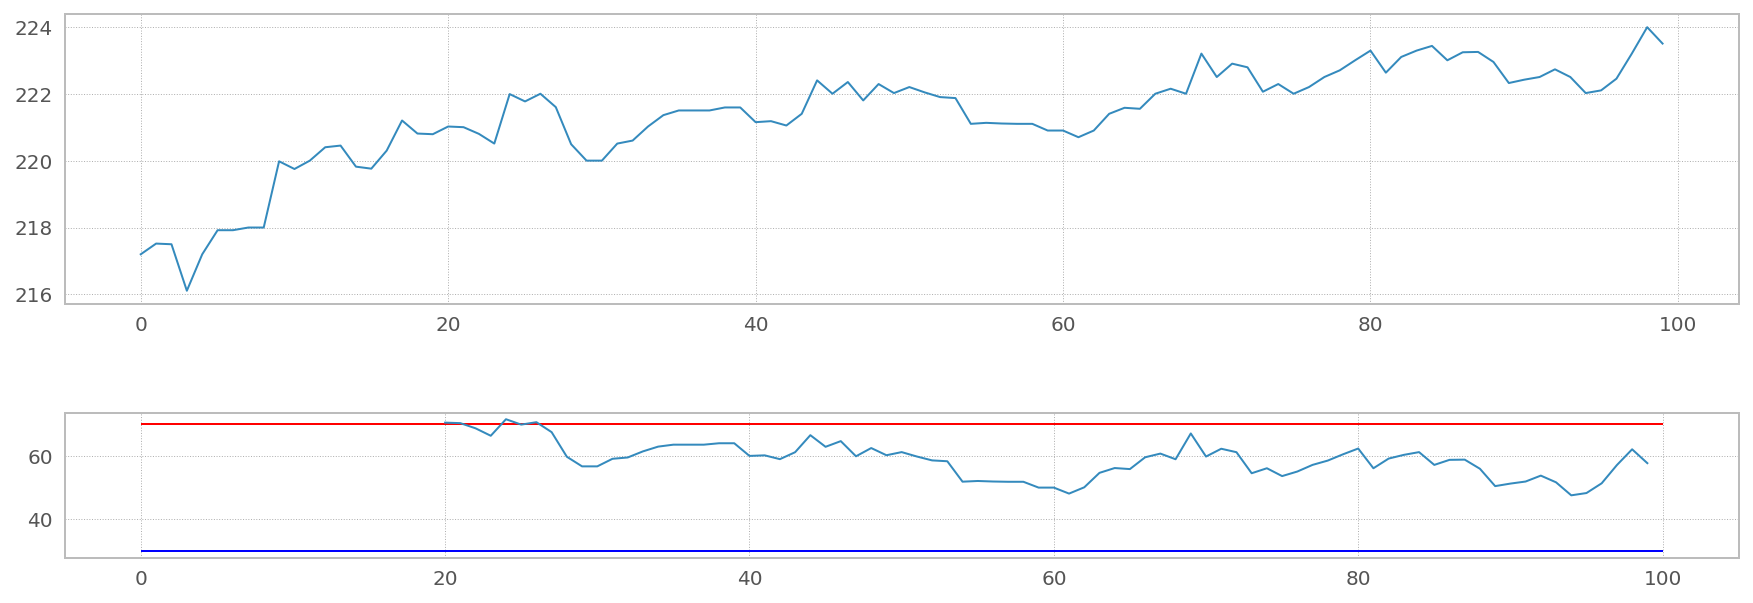

In [7]:
from talib import RSI

rsi = RSI(ts, 20)
_, (ax, ax2) = plt.subplots(2, 1, gridspec_kw={"height_ratios": [2, 1]})
ax.plot(ts[:100])
ax2.plot(rsi[:100])
ax2.hlines(30, 0,100, color="blue") # buy
ax2.hlines(70, 0,100, color="red"); # sell